# 의사결정트리 (Titianic)

## 01. 패키지 참조

In [33]:
import numpy as np
import seaborn as sb
import os 
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

## 02. 데이터 가져오기

#### csv 파일 읽기

In [3]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
print(train.shape, test.shape)
train.head()

(891, 12) (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


#### 데이터 프레임 원본 백업

In [5]:
origin_train  = train.copy()
origin_test = test.copy()

#### 훈련 데이터와 검증 데이터를 병합하여 전체 데이터셋 구성

In [8]:
full_data = [train, test]
print(type(full_data)) # 데이터 프레임을`[]으로` 묶으면 list로 바뀐다
full_data

<class 'list'>


[     PassengerId  Survived  Pclass  \
 0              1         0       3   
 1              2         1       1   
 2              3         1       3   
 3              4         1       1   
 4              5         0       3   
 ..           ...       ...     ...   
 886          887         0       2   
 887          888         1       1   
 888          889         0       3   
 889          890         1       1   
 890          891         0       3   
 
                                                   Name     Sex   Age  SibSp  \
 0                              Braund, Mr. Owen Harris    male  22.0      1   
 1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
 2                               Heikkinen, Miss. Laina  female  26.0      0   
 3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
 4                             Allen, Mr. William Henry    male  35.0      0   
 ..                                               

## 03. 데이터 전처리

### 객실 유무

In [16]:
train['CabinO'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['CabinO'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)


### 가족 구성원 수

In [24]:
train['FamilySize'] = train["SibSp"] + train['Parch']
test['FamilySize'] = test['SibSp'] + test["Parch"]

### 혼자 탑승했는지 여부

In [25]:
train['ISAlone'] = 0
train.loc[train["FamilySize"] == 1, "ISAlone"] = 1

test['ISAlone'] = 0
test.loc[test["FamilySize"] == 1, "ISAlone"] = 1

### 탑승지 결측치 처리

#### 소수의 결측치 데이터(train 기준 2건) 최빈값인 'S'로 대체

In [27]:
train["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [28]:
train["Embarked"] = train["Embarked"].fillna("S")
test["Embarked"] = test["Embarked"].fillna("S")

### 요금 데이터의 결측치 처리

In [49]:
train["Fare"] = train['Fare'].fillna(train['Fare'].median())
test["Fare"] = test['Fare'].fillna(test['Fare'].median())

### 나이 데이터의 결측치 처리
#### 훈련용 데이터

In [31]:
age_avg = train['Age'].mean()
age_std = train['Age'].std()
age_null_count = train['Age'].isnull().sum()
age_null_rnd_list = np.random.randint(age_avg - age_std,age_avg +age_std, size=age_null_count)

# 결측치에 해당하는 행에 랜덤값을 채워준다.
train.loc[np.isnan(train['Age']), 'Age'] = age_null_rnd_list

train['Age'] = train['Age'].astype(int)

#### 검증 데이터

In [32]:
age_avg = test['Age'].mean()
age_std = test['Age'].std()
age_null_count = test['Age'].isnull().sum()
age_null_rnd_list = np.random.randint(age_avg - age_std,age_avg +age_std, size=age_null_count)

# 결측치에 해당하는 행에 랜덤값을 채워준다.
test.loc[np.isnan(test['Age']), 'Age'] = age_null_rnd_list

test['Age'] = test['Age'].astype(int)

#### 정규표현식 처리 함수

이름에서 알파벳을 제외한 나머지 글자를 제외하고 어절단위로 리스트로 묶은 후 인덱스가 1인 위치를 리턴하는 함수

In [34]:
import re

def get_title(name):
    title_search = re.search(r'([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return None  # Return None if no title is found


In [35]:
train['Title'] = train['Name'].apply(get_title)

print(list(train['Title'].value_counts().index))

['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev', 'Mlle', 'Major', 'Col', 'Countess', 'Capt', 'Ms', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer']


In [36]:
train['Title'] = train['Title'].replace(['Dr','Rev', 'Mlle', 'Major', 'Col', 
                                         'Countess', 'Capt', 'Ms', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer'], "Rare")

In [37]:
test['Title'] = test['Name'].apply(get_title)

test['Title'] = test['Title'].replace(['Dr','Rev', 'Mlle', 'Major', 'Col', 
                                         'Countess', 'Capt', 'Ms', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer'], "Rare")

### 데이터 라벨링
#### 성별

In [40]:
train['Sex'] = train['Sex'].map({"female":0, "male":1})
test['Sex'] = test['Sex'].map({"female":0, "male":1})

#### 호칭

In [41]:
train['Title'] = train['Title'].map({'Mr' : 0, 'Miss' : 1, 'Mrs' : 2, 'Master' : 3})
test['Title'] = test['Title'].map({'Mr' : 0, 'Miss' : 1, 'Mrs' : 2, 'Master' : 3})

#### 탑승지

In [42]:
train['Embarked'] = train['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
test['Embarked'] = test['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

#### 연령대 분할

In [44]:
train.loc[train['Age'] <= 16, "Age"] = 0
train.loc[(train['Age'] > 16) & (train['Age'] <= 32), "Age"] = 1
train.loc[(train['Age'] > 32) & (train['Age'] <= 48), "Age"] = 2
train.loc[(train['Age'] > 48) & (train['Age'] <= 64), "Age"] = 3

test.loc[test['Age'] <= 16, "Age"] = 0
test.loc[(test['Age'] > 16) & (test['Age'] <= 32), "Age"] = 1
test.loc[(test['Age'] > 32) & (test['Age'] <= 48), "Age"] = 2
test.loc[(test['Age'] > 48) & (test['Age'] <= 64), "Age"] = 3


#### 탑승 요금 분할

탑승요금의 최대/최소, 사분위 수 확인

In [45]:
train['Fare'].quantile([0,0.25,0.5,0.75,1])

0.00      0.0000
0.25      7.9104
0.50     14.4542
0.75     31.0000
1.00    512.3292
Name: Fare, dtype: float64

In [47]:
train.loc[train['Fare'] <= 7.9104, "Fare"] = 0
train.loc[(train['Fare'] > 7.9104) & (train['Fare'] <= 14.4542), "Fare"] = 1
train.loc[(train['Fare'] > 14.4542) & (train['Fare'] <= 31), "Fare"] = 2
train.loc[(train['Fare'] > 31) & (train['Fare'] <= 512.2392), "Fare"] = 3

test.loc[test['Fare'] <= 7.9104, "Fare"] = 0
test.loc[(test['Fare'] > 7.9104) & (test['Fare'] <= 14.4542), "Fare"] = 1
test.loc[(test['Fare'] > 14.4542) & (test['Fare'] <= 31), "Fare"] = 2
test.loc[(test['Fare'] > 31) & (test['Fare'] <=512.2392), "Fare"] = 3


In [50]:
drop_element = ['PassengerId','Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_element,axis=1)
test = test.drop(drop_element,axis=1)

train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,CabinO,FamilySize,ISAlone,Title
0,0,3,1,1,0,0.0,0,0,1,1,0.0
1,1,1,0,2,0,3.0,1,1,1,1,2.0
2,1,3,0,1,0,1.0,0,0,0,0,1.0
3,1,1,0,2,0,3.0,0,1,1,1,2.0
4,0,3,1,2,0,1.0,0,0,0,0,0.0


### 전처리 결과 확인

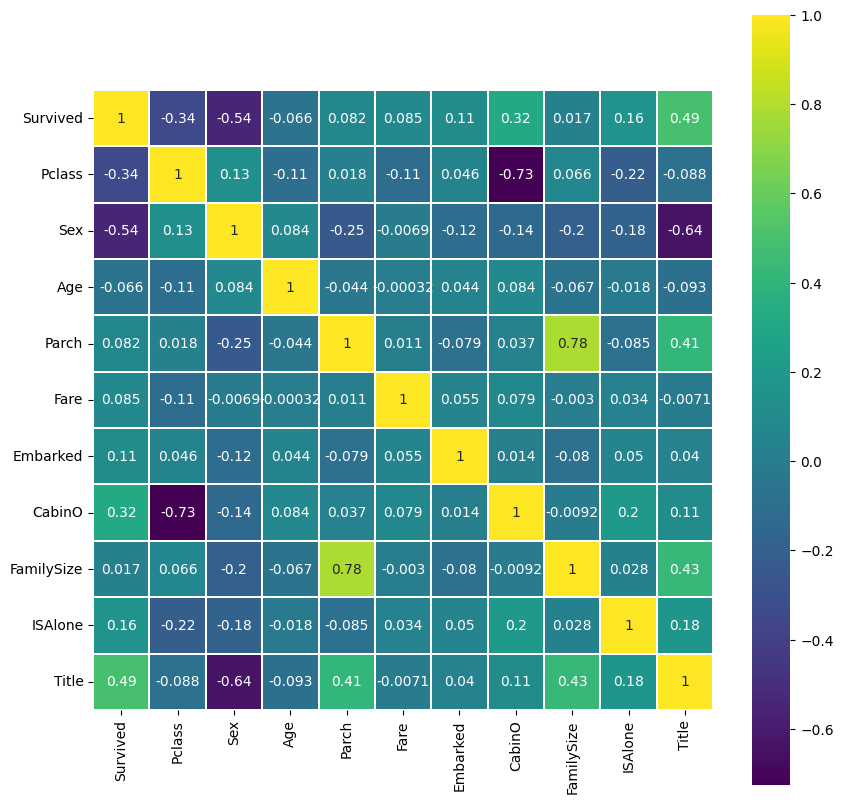

In [52]:
plt.figure(figsize=(10,10))

sb.heatmap(train.astype(float).corr(), linewidths=0.1, vmax= 1.0, square = True,
           cmap = plt.cm.viridis, linecolor = 'white', annot = True)

plt.show()
plt.close()